In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import re
import seaborn as sns
import numpy as np
import pandas as pd
import math

from matplotlib import pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.layers as L



from kaggle_datasets import KaggleDatasets

In [2]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [3]:
# For tf.dataset
AUTO = tf.data.experimental.AUTOTUNE

# Data access
GCS_PATH = KaggleDatasets().get_gcs_path('siim-isic-melanoma-classification')

# Configuration
EPOCHS = 12
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
IMAGE_SIZE = [1024, 1024]


In [4]:
def append_path(pre):
    return np.vectorize(lambda file: os.path.join(GCS_DS_PATH, pre, file))

In [5]:
# read the training and sample submission files

sub = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/sample_submission.csv')
train = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/train.csv')


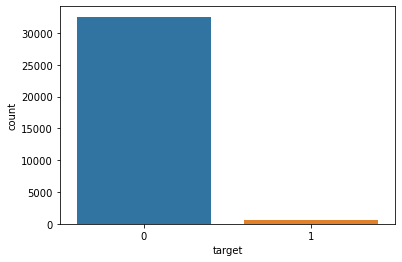

In [6]:
sns.countplot(train['target'])

In [7]:
# getting the training and testing filenames
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/tfrecords/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/tfrecords/test*.tfrec')

CLASSES = [0,1]

In [8]:
#  Lets look at how the training file names look like
TRAINING_FILENAMES[:3]

['gs://kds-599205fd0d8963558ce1308147ba090f776d31b1662a67f2ddccfa38/tfrecords/train00-2071.tfrec',
 'gs://kds-599205fd0d8963558ce1308147ba090f776d31b1662a67f2ddccfa38/tfrecords/train01-2071.tfrec',
 'gs://kds-599205fd0d8963558ce1308147ba090f776d31b1662a67f2ddccfa38/tfrecords/train02-2071.tfrec']

In [22]:

def decode_image(image_data):
    image =  tf.image.decode_jpeg(image_data, channels = 3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image



def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image" : tf.io.FixedLenFeature([], tf.string),
        "target" : tf.io.FixedLenFeature([], tf.int64)
    }
    
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['target'], tf.int32)
    return image, label


def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image" : tf.io.FixedLenFeature([], tf.string),
        "image_name" : tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    id_num = example['image_name']
    return image, id_num
    
    
def load_dataset(filenames, labeled = True, ordered = False):
    
    # disregarding  the  data order
    ignore_order = tf.data.Options()
    
    if not ordered:
        # disabling the order to increase speed
        ignore_order.experimental_deterministic = False
        
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO) #automatically reads from different files
    dataset =  dataset.with_options(ignore_order) # reads dataset as it comes in rather than its original order
    
    # returns a dataset of (image,  label) if labele is true else returns (image, id) if unlabeled
    dataset  = dataset.map(read_labeled_tfrecord if  labeled else read_unlabeled_tfrecord,
                           num_parallel_calls = AUTO)
    
    return dataset


def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    return image, label


def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled = True)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.repeat() # the training  dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch the next batch while training (autotune prefetch buffer size)
    return dataset


def get_validation_dataset(ordered = False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled = True, ordered = ordered)
    dataset =  dataset.batch(BATCH_SIZE)
    dataset =  dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch the next batch while training (autotune prefetch buffer size)
    return dataset
    
    
    
def get_test_dataset(ordered = False):
    dataset = load_dataset(TEST_FILENAMES, labeled = False, ordered = ordered)
    dataset =  dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch the next batch while training (autotune prefetch buffer size)
    return dataset
    
    
    
def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)
    
    
    
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
print('Dataset: {} training images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_TEST_IMAGES))

Dataset: 33126 training images, 10982 unlabeled test images


In [14]:
with strategy.scope():
    model = tf.keras.Sequential([
        tf.keras.applications.ResNet50(
            weights =  'imagenet',
            input_shape  = [*IMAGE_SIZE, 3],
            include_top =  False
        ),
        L.GlobalAveragePooling2D(),
        L.Dense(1024, activation = 'relu'), 
        L.Dropout(0.3), 
        L.Dense(512, activation= 'relu'), 
        L.Dropout(0.2), 
        L.Dense(256, activation='relu'), 
        L.Dropout(0.2), 
        L.Dense(128, activation='relu'), 
        L.Dropout(0.1), 
        L.Dense(1, activation='sigmoid')
        
    ]) 
    
    
model.compile(loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.1),
             metrics = ['accuracy'],
             optimizer =  'adam')

model.summary()
    
    

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 32, 32, 2048)      23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)              

In [23]:
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

history = model.fit(
            get_training_dataset(),
            epochs = EPOCHS,
            steps_per_epoch = STEPS_PER_EPOCH,
            verbose= 1
)

AttributeError: in user code:

    <ipython-input-20-45cd845e23c5>:16 read_labeled_tfrecord  *
        image = decode_image(example['image'])
    <ipython-input-20-45cd845e23c5>:2 decode_image  *
        image =  tf.image.decode_jpg(image_data, channels = 3)

    AttributeError: module 'tensorflow._api.v2.image' has no attribute 'decode_jpg'
